# Load Libraries and Data

In [1]:
# import libraries
import numpy as np  
import pandas as pd  
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler, QuantileTransformer, PowerTransformer
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

from hyperopt import fmin, tpe, hp, Trials


# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data 
train_data = pd.read_csv('/kaggle/input/cse-281-24-predict-the-item-price/train.csv')
test_data = pd.read_csv('/kaggle/input/cse-281-24-predict-the-item-price/test.csv')

train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


# Data Content

In [3]:
train_data.shape

(6000, 12)

In our data there are 6000 different items and 12 features.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      6000 non-null   object 
 1   X2      4994 non-null   float64
 2   X3      6000 non-null   object 
 3   X4      6000 non-null   float64
 4   X5      6000 non-null   object 
 5   X6      6000 non-null   float64
 6   X7      6000 non-null   object 
 7   X8      6000 non-null   int64  
 8   X9      4289 non-null   object 
 9   X10     6000 non-null   object 
 10  X11     6000 non-null   object 
 11  Y       6000 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 562.6+ KB


Feature types:
1. 'X1', 'X3', 'X5', 'X7', 'X9', 'X10', 'X11' are categorical features
2. 'X2', 'X4', 'X6', 'X8', 'Y' are numerical features

In [5]:
# Getting the number of missing values in each column
train_data.isnull().sum().sort_values(ascending=False)

X9     1711
X2     1006
X1        0
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X10       0
X11       0
Y         0
dtype: int64

We got that:
- 1711 missing values in X9, which is categorical feature 
- 1006 missing values in X2, which is numerical feature

For dealing with missing values, you should ask yourself about the nature of the missing values. Are they missing at random, or are they missing not at random?

# Exploratory Data Analysis - EDA

## Univariate Analysis

### numerical features

In [6]:
numerical_features = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features

['X2', 'X4', 'X6', 'X8', 'Y']

In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
X2,4994.0,12.956536,4.658851,4.555,8.89500,12.80000,17.100000,21.350000
X4,6000.0,0.066333,0.051492,0.000,0.02703,0.05462,0.095154,0.328391
X6,6000.0,141.228200,62.540569,31.290,94.03765,143.19700,186.522050,266.888400
X8,6000.0,1997.840333,8.334412,1985.000,1987.00000,1999.00000,2004.000000,2009.000000
Y,6000.0,7.303403,1.014361,3.510,6.75000,7.50000,8.040000,9.400000


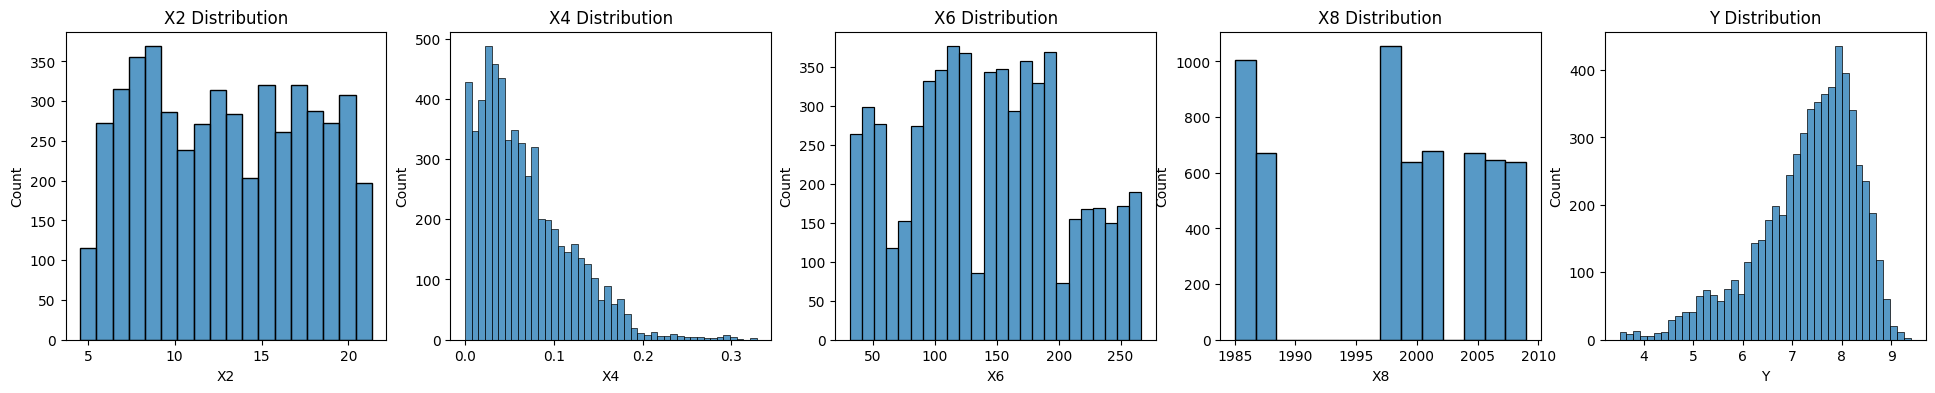

In [8]:
# Ploting numerical features
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(24, 4))

for i, feature in enumerate(numerical_features):
    sns.histplot(train_data[feature], kde=False, ax=ax[i])
    ax[i].set_title(f'{feature} Distribution', fontsize=12)

**Observations**:
- X2: range from 4.55 to 21.35
- X4: is right skewed
- X8: no values between 1990 and 1995
- Y: is smth like a normal distribution but left skewed

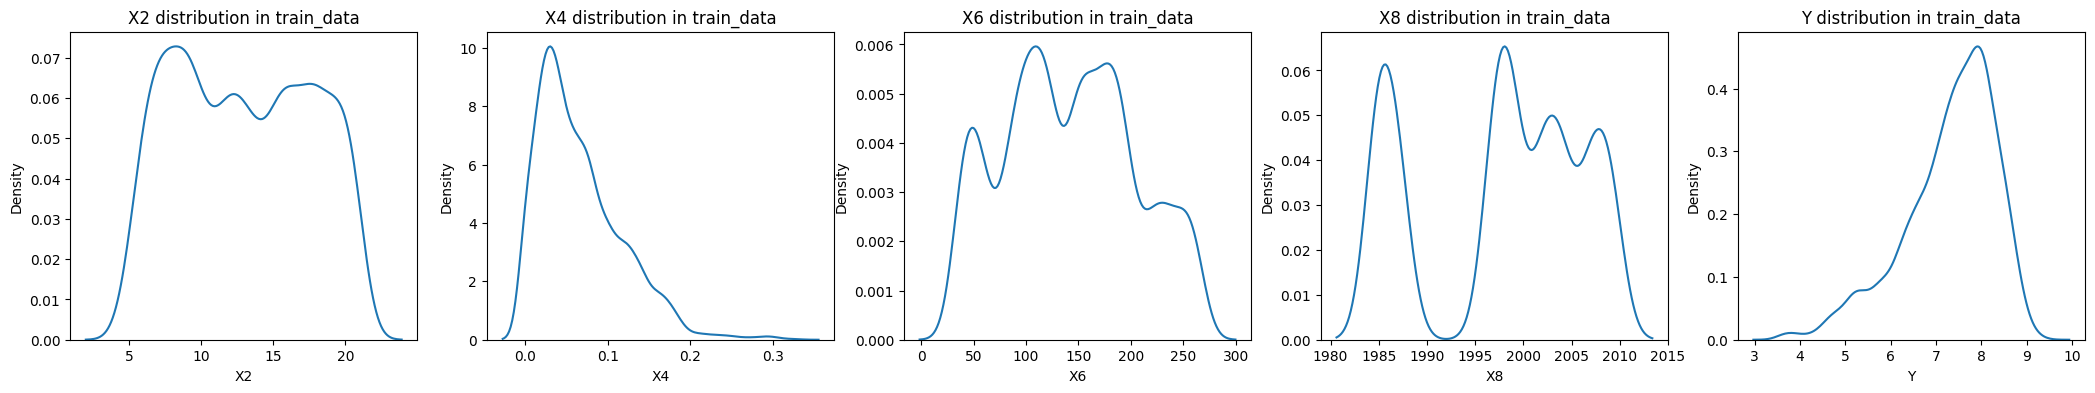

In [9]:
# Train data distribution
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numerical_features):
    sns.kdeplot(data=train_data, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in train_data')

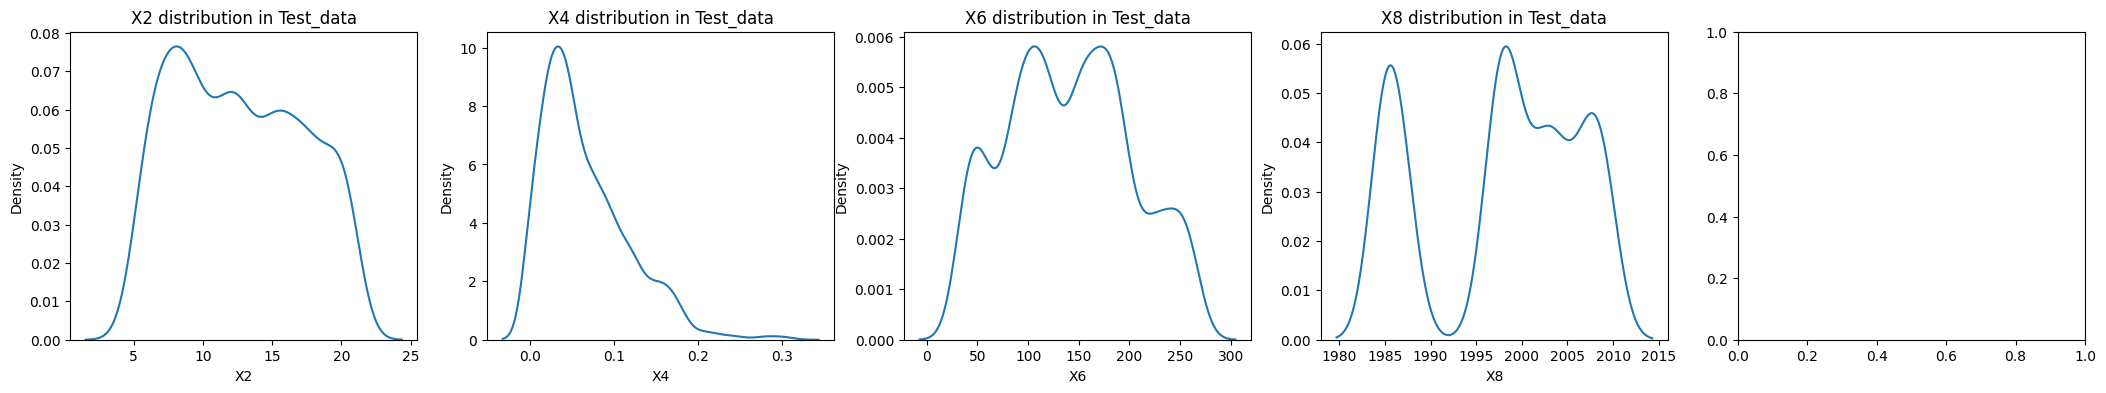

In [10]:
# Test data distribution
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numerical_features[:-1]): # [:-1] to exclude Y (target column)
    sns.kdeplot(data=test_data, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test_data')

IDK what is the problem with X2 :D

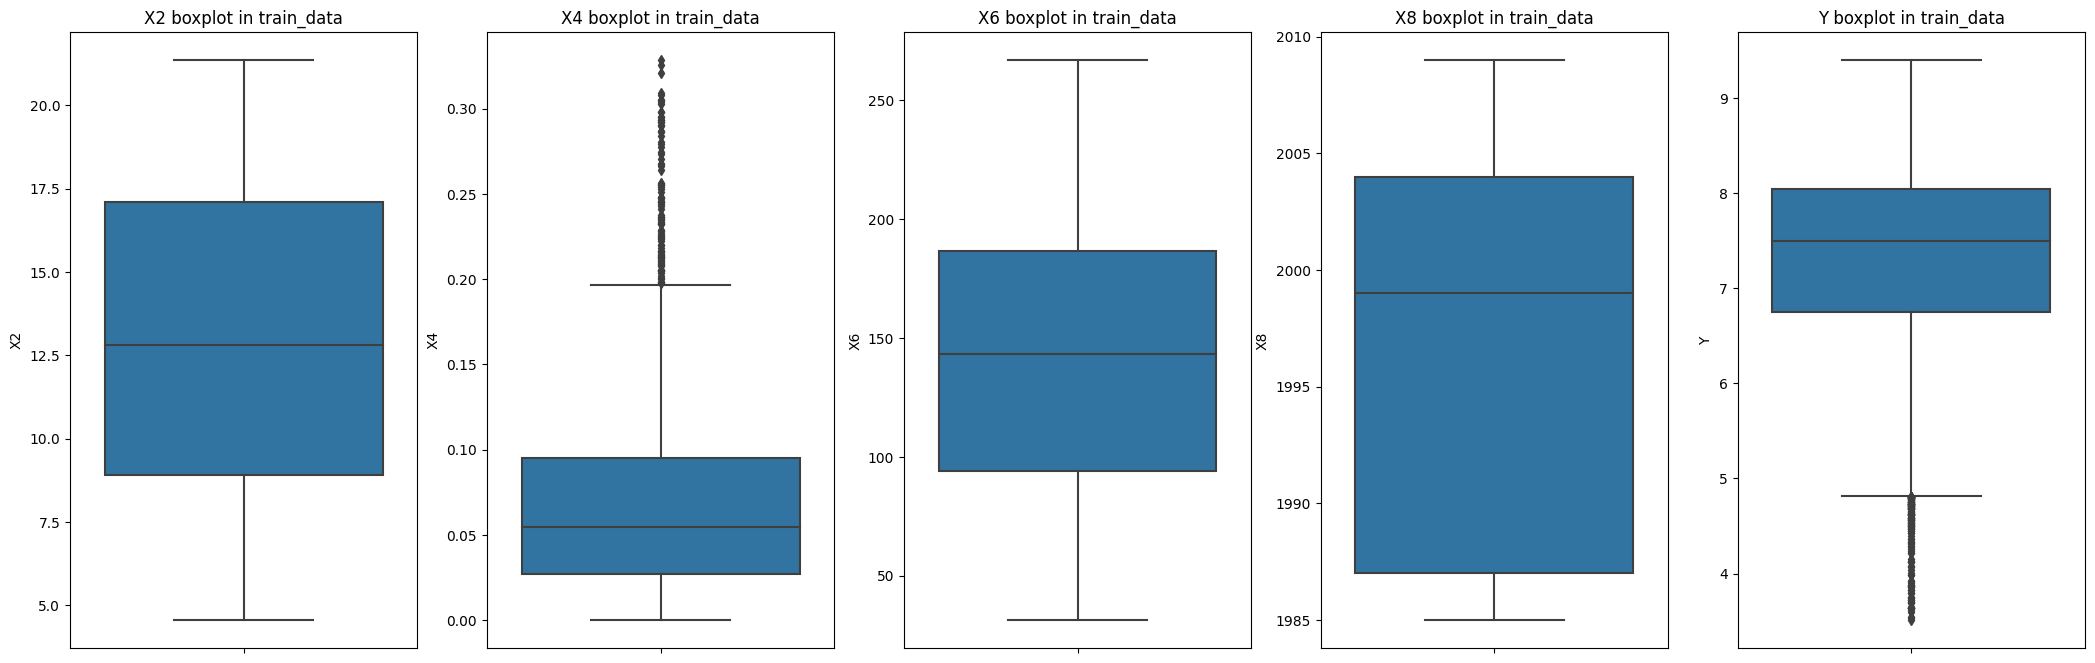

In [11]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numerical_features):
    sns.boxplot(data=train_data, y=col, ax=ax[index])
    ax[index].set_title(f'{col} boxplot in train_data')

**Observations:**
- X4 and Y have outliers, the same thing with test data also

### categorical features

In [12]:
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['X1', 'X3', 'X5', 'X7', 'X9', 'X10', 'X11']

In [13]:
small_cat_cols = ['X3', 'X5', 'X7', 'X9', 'X10', 'X11']
for col in small_cat_cols:
    print(f'Number of values in {col} column: {train_data[col].value_counts()}')

Number of values in X3 column: X3
Low Fat    3595
Regular    2030
LF          220
reg          81
low fat      74
Name: count, dtype: int64
Number of values in X5 column: X5
Fruits and Vegetables    875
Snack Foods              840
Household                643
Frozen Foods             621
Dairy                    487
Canned                   455
Baking Goods             454
Health and Hygiene       342
Soft Drinks              311
Meat                     294
Breads                   182
Hard Drinks              150
Others                   117
Starchy Foods            108
Breakfast                 75
Seafood                   46
Name: count, dtype: int64
Number of values in X7 column: X7
OUT045    677
OUT013    672
OUT035    671
OUT046    664
OUT027    659
OUT017    644
OUT049    639
OUT018    637
OUT010    390
OUT019    347
Name: count, dtype: int64
Number of values in X9 column: X9
Medium    1935
Small     1682
High       672
Name: count, dtype: int64
Number of values in X10 column:

In [14]:
for col in small_cat_cols:
  print(col, train_data[col].unique().tolist())

X3 ['Low Fat', 'Regular', 'low fat', 'LF', 'reg']
X5 ['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables', 'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods', 'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned', 'Breads', 'Starchy Foods', 'Others', 'Seafood']
X7 ['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045', 'OUT017', 'OUT046', 'OUT035', 'OUT019']
X9 ['Medium', nan, 'High', 'Small']
X10 ['Tier 1', 'Tier 3', 'Tier 2']
X11 ['Supermarket Type1', 'Supermarket Type2', 'Grocery Store', 'Supermarket Type3']


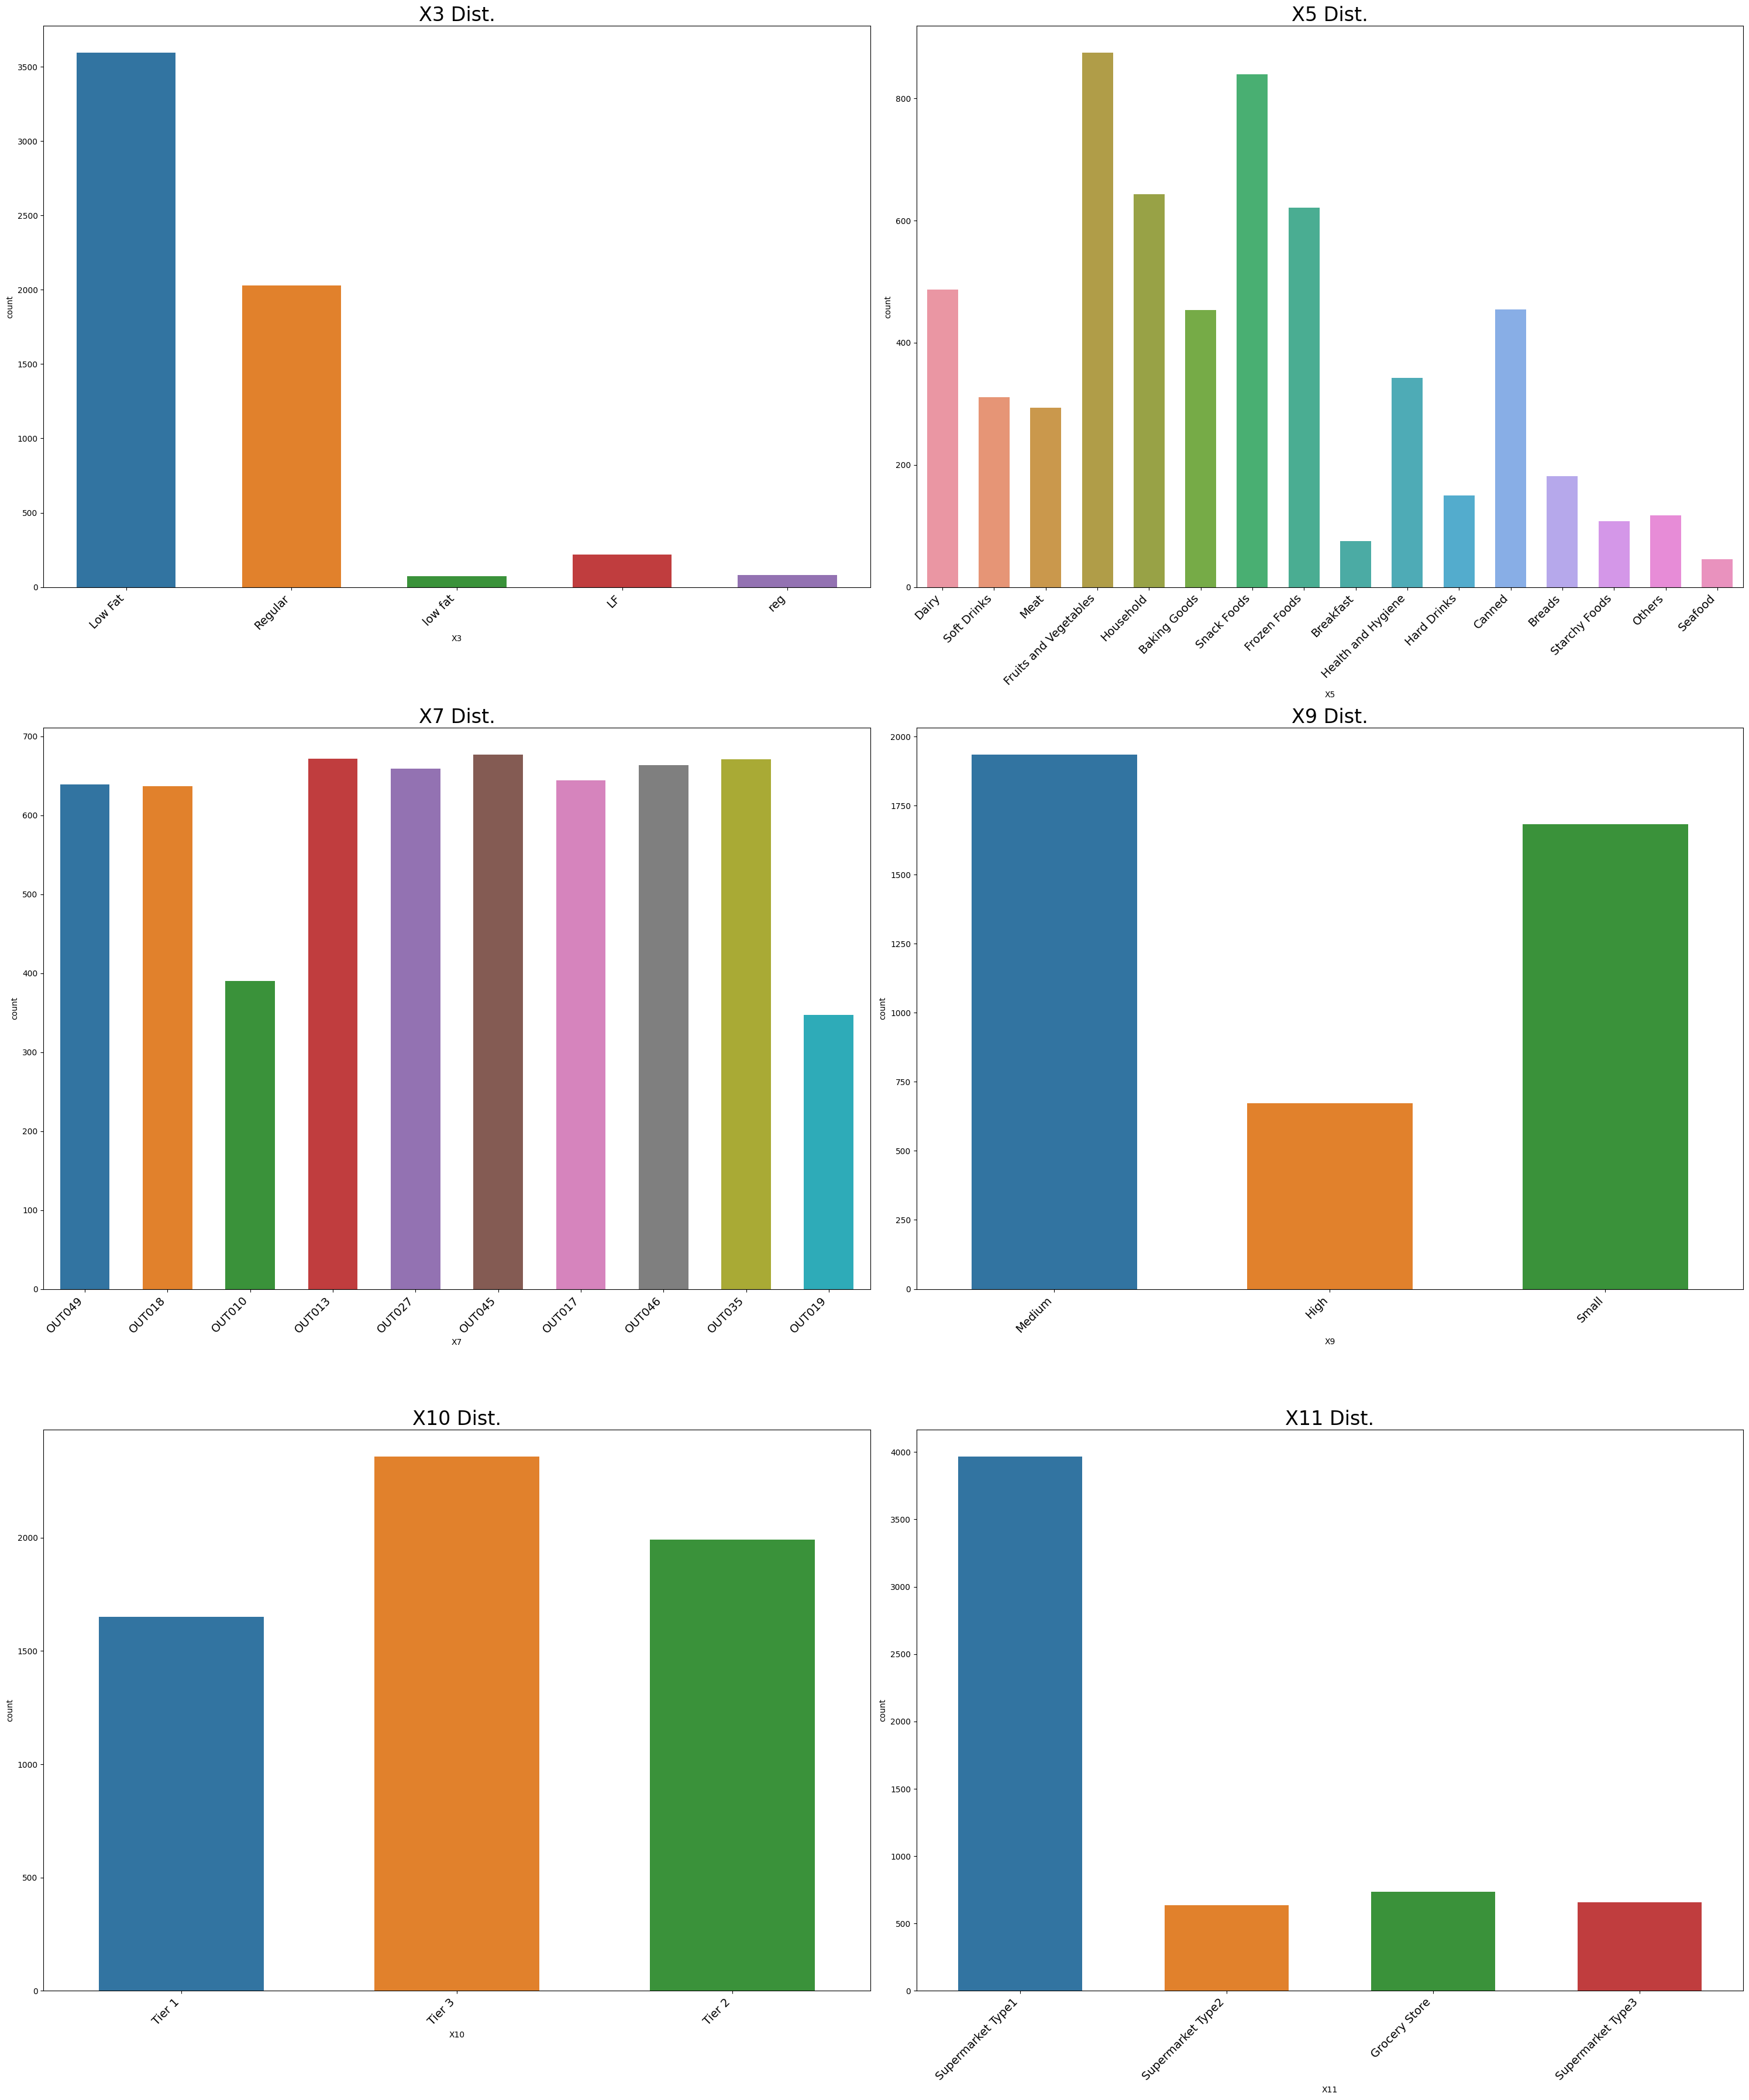

In [15]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 36))

for index, col in enumerate(small_cat_cols):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=train_data, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=14)
    ax[r][c].set_title(f'{col} Dist.', fontsize=24)
    plt.tight_layout()

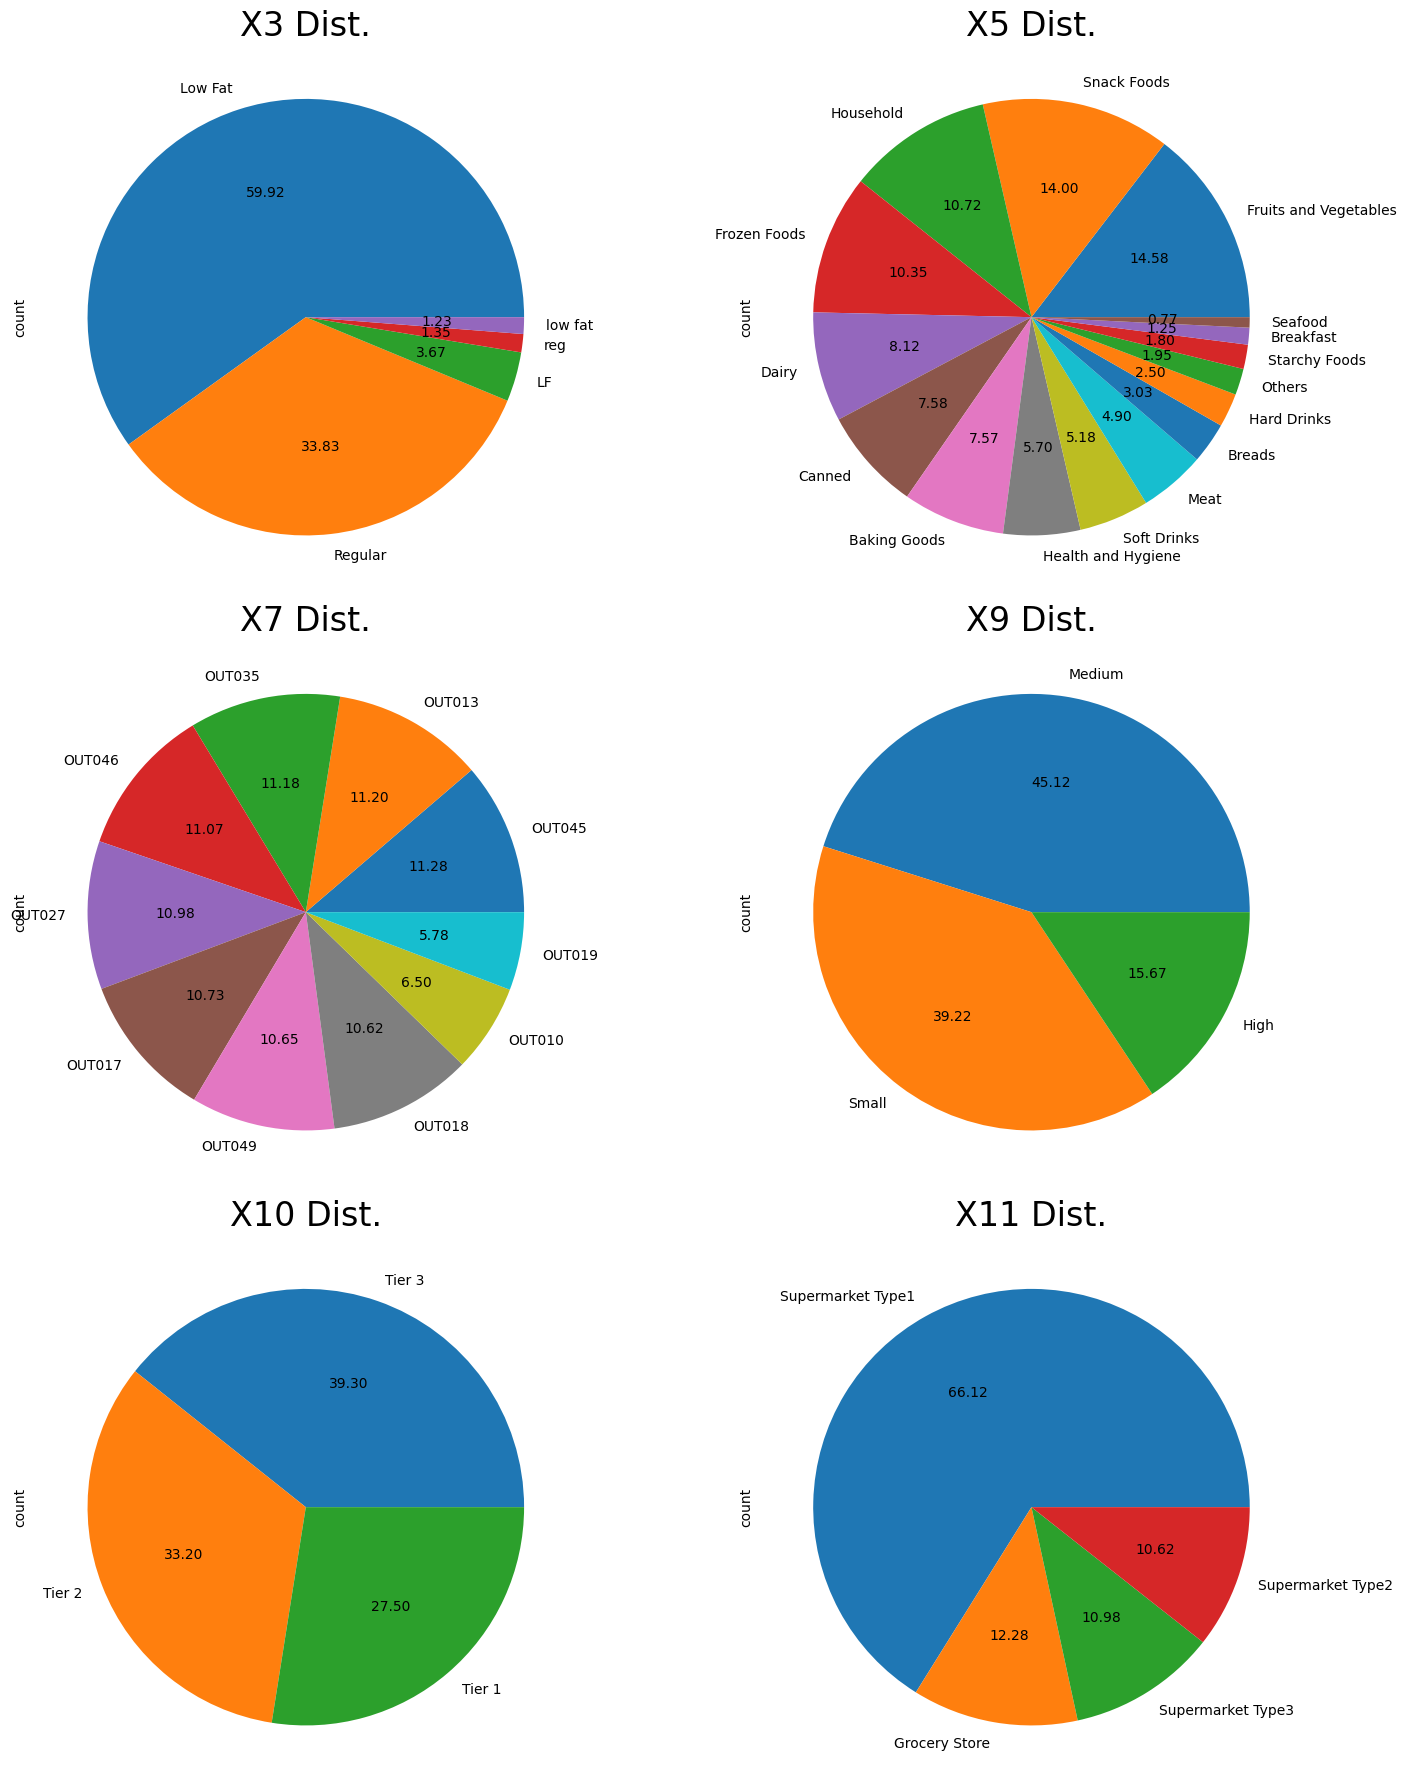

In [16]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for index, col in enumerate(small_cat_cols):
    r = index // 2
    c = index % 2
    train_data[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} Dist.', fontsize=24)
    plt.tight_layout()

**Observations:**
- X3 has values need to be mapped, 'LF', 'low fat' and 'Low Fat' are the same thing, 'reg' and 'Regular' are the same thing, maybe we can make it binary feature
- X5 has 16 features, we can reduce them 
- X10 can be mapped to 1, 2, 3

After looking at the data, we can see that each value in X7 has a static set of values in X8, X9, X10, X11. So, we can use this information to drop these columns.

In [17]:
train_data.groupby('X7')[['X8', 'X9', 'X10', 'X11']].nunique()

,X8,X9,X10,X11
X7,,,,
OUT010,1,0,1,1
OUT013,1,1,1,1
OUT017,1,0,1,1
OUT018,1,1,1,1
OUT019,1,1,1,1
OUT027,1,1,1,1
OUT035,1,1,1,1
OUT045,1,0,1,1
OUT046,1,1,1,1


In [18]:
# Drop columns X8, X9, X10, X11 because we no longer need them
train_data.drop(['X8', 'X9', 'X10', 'X11'], axis=1, inplace=True)
test_data.drop(['X8', 'X9', 'X10', 'X11'], axis=1, inplace=True)

categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist() # Update categorical
numerical_features = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist() # Update numerical features list

train_data.head()

,X1,X2,X3,X4,X5,X6,X7,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,6.90


## Bivariate Analysis

### numerical with numerical

In [19]:
target_col = 'Y'

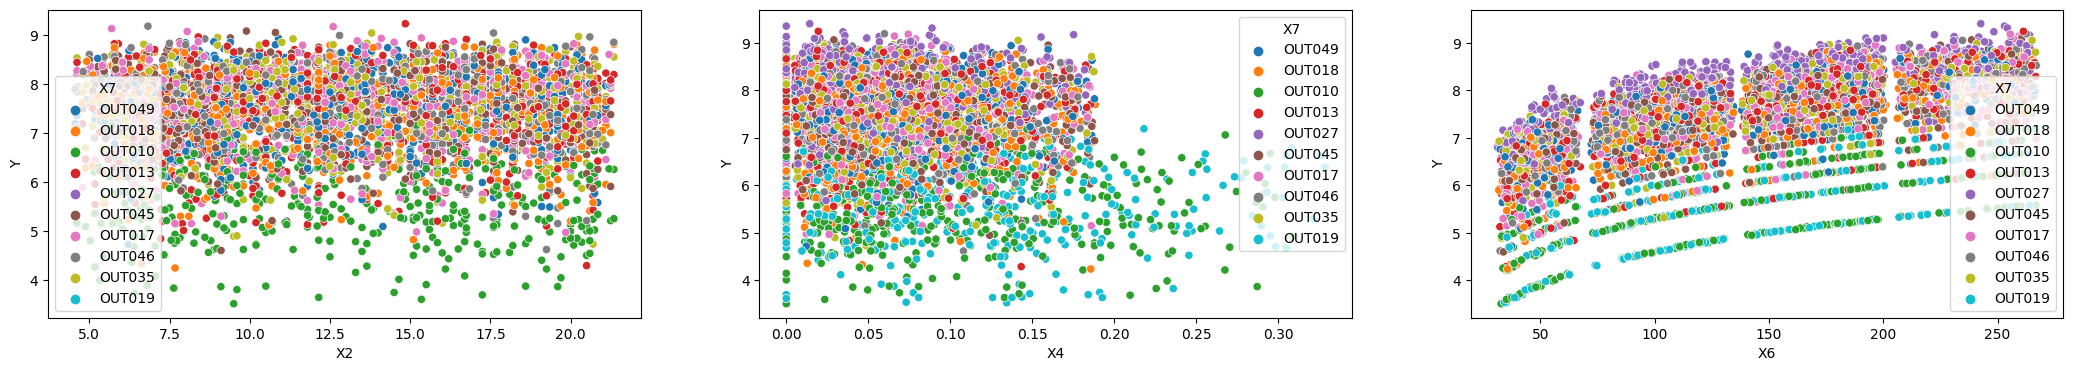

In [20]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['X2', 'X4', 'X6']):
      sns.scatterplot(data=train_data,x=col, y=target_col, ax=ax[index], hue='X7')


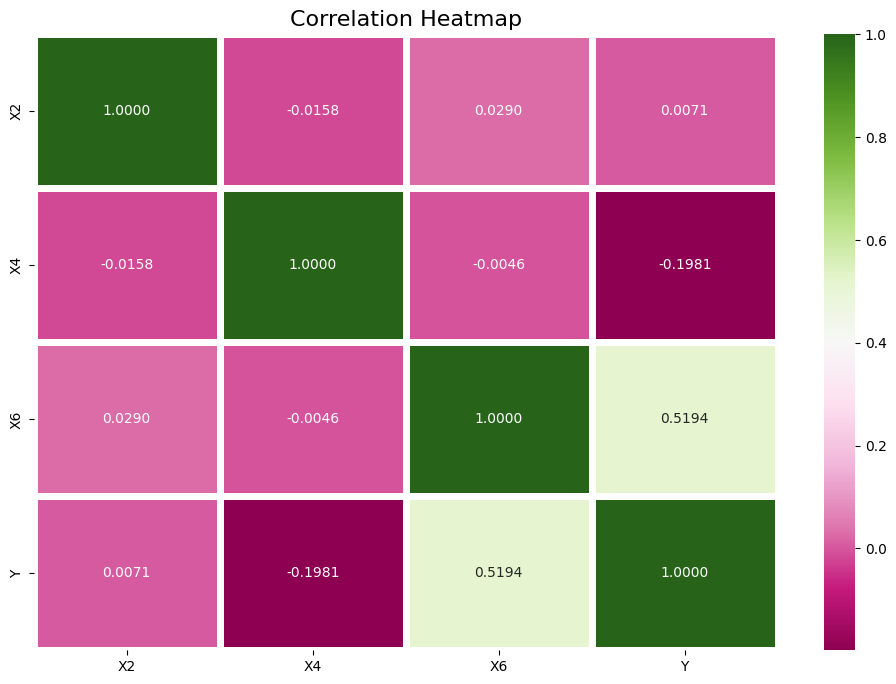

In [21]:
# Filter numeric columns
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Draw the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', fmt='.4f', linewidths=5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

### numerical with categorical

In [22]:
# Missing values
train_data.isnull().sum().sort_values(ascending=False)

X2    1006
X1       0
X3       0
X4       0
X5       0
X6       0
X7       0
Y        0
dtype: int64

# Data Preprocessing

## Missing Values Handling

In [23]:
# TODO, we can fill more values using   the correct values in test and train (combine between them)
# I noticed that for all X1 values, the corresponding X2 value is the same. So, I will ...
# fill the missing X2 using X2 value in another row with the same X1 value.
def group_imputation(data):
    for idx, row in data[data['X2'].isnull()].iterrows():
        # Find rows with the same X1 value but non-null X2
        matching_rows = data[(data['X1'] == row['X1']) & (data['X2'].notnull())]
        
        if not matching_rows.empty:
            # Use the first matching row's X2 value to fill the missing X2
            data.at[idx, 'X2'] = matching_rows.iloc[0]['X2']
    return data

train_data = group_imputation(train_data)
test_data = group_imputation(test_data)

# # Step 2: Apply KNN imputation for any remaining missing values in X2
# knn_imputer = KNNImputer(n_neighbors=27)
# train_data[['X2']] = knn_imputer.fit_transform(train_data[['X2']])
# test_data[['X2']] = knn_imputer.fit_transform(test_data[['X2']])

# Filling remaining null X2 using regression.... 

# Split data into missing and non-missing 
X2_train_row_missing = train_data[train_data['X2'].isnull()]
X2_test_row_missing = test_data[test_data['X2'].isnull()]
X2_non_missing = train_data[train_data['X2'].notnull()]

# Prepare training data
X2_X_train = X2_non_missing.drop(columns=['X2'])
X2_y_train = X2_non_missing['X2']

X2_X_train_missing = X2_train_row_missing.drop(columns=['X2'])
X2_X_test_missing = X2_test_row_missing.drop(columns=['X2'])

# Handle categorical features (if any)
X2_X_train = pd.get_dummies(X2_X_train)
X2_X_train_missing = pd.get_dummies(X2_X_train_missing).reindex(columns=X2_X_train.columns, fill_value=0)
X2_X_test_missing = pd.get_dummies(X2_X_test_missing).reindex(columns=X2_X_train.columns, fill_value=0)

# Initialize and fit the regressor
X2_regressor = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
X2_regressor.fit(X2_X_train, X2_y_train)

# Fill missing values
if not X2_X_train_missing.empty:
    train_data.loc[train_data['X2'].isnull(), 'X2'] = X2_regressor.predict(X2_X_train_missing)

if not X2_X_test_missing.empty:
    test_data.loc[test_data['X2'].isnull(), 'X2'] = X2_regressor.predict(X2_X_test_missing)

# we no longer need to fill X9 because we dropped it earlier
# # Filling X9 using KNN....

# # TODO , assign best K values 

# # Step 1: Encode categorical column
# X9_encoder = OrdinalEncoder()
# train_data['X9_encoded'] = X9_encoder.fit_transform(train_data[['X9']])
# test_data['X9_encoded'] = X9_encoder.transform(test_data[['X9']])

# # Step 2: Apply KNN Imputer to fill missing values
# knn_imputer = KNNImputer(n_neighbors=9)  # Adjust n_neighbors as needed
# train_data['X9_encoded'] = knn_imputer.fit_transform(train_data[['X9_encoded']])
# test_data['X9_encoded'] = knn_imputer.transform(test_data[['X9_encoded']])

# # Step 3: Decode back to the original categories
# train_data['X9'] = X9_encoder.inverse_transform(train_data[['X9_encoded']]).ravel()
# test_data['X9'] = X9_encoder.inverse_transform(test_data[['X9_encoded']]).ravel()

# # Step 4: Drop intermediate encoded column (if no longer needed)
# train_data.drop(columns=['X9_encoded'], inplace=True)
# test_data.drop(columns=['X9_encoded'], inplace=True)

In [24]:
# get the number of missing datapoints per column
train_data.isnull().sum()
test_data.isnull().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
dtype: int64

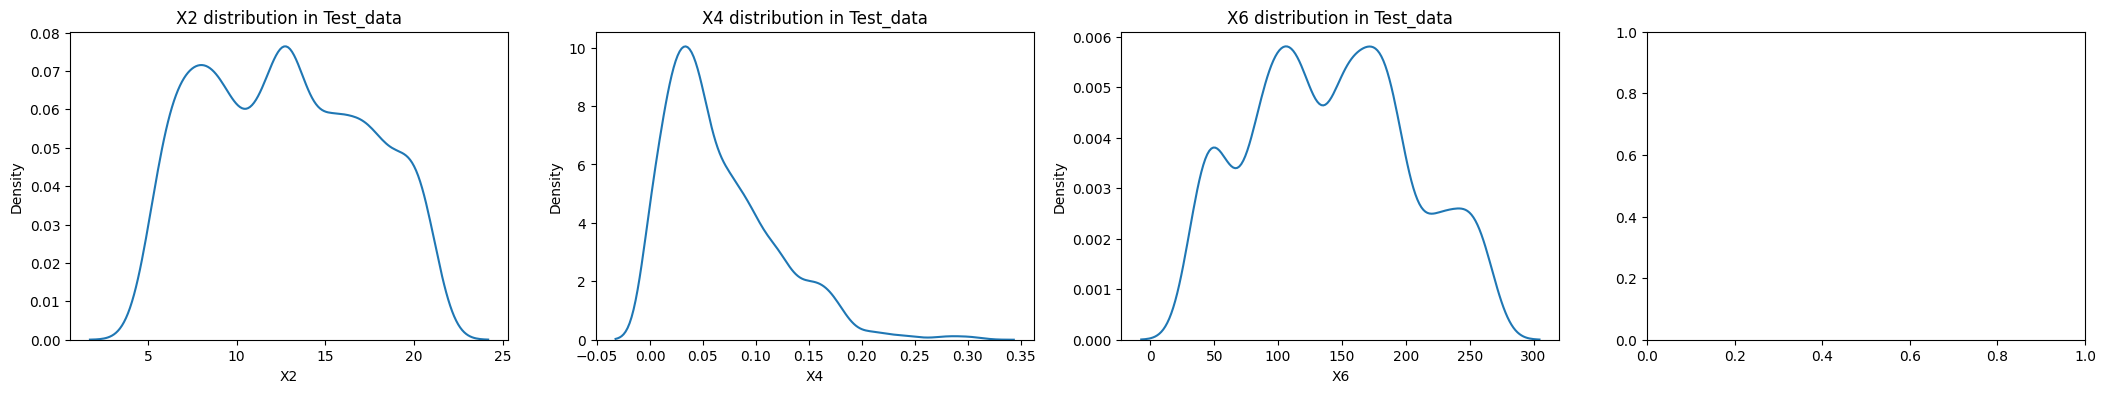

In [25]:
# Test data distribution
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 4))

for index, col in enumerate(numerical_features[:-1]): # [:-1] to exclude Y (target column)
    sns.kdeplot(data=test_data, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test_data')

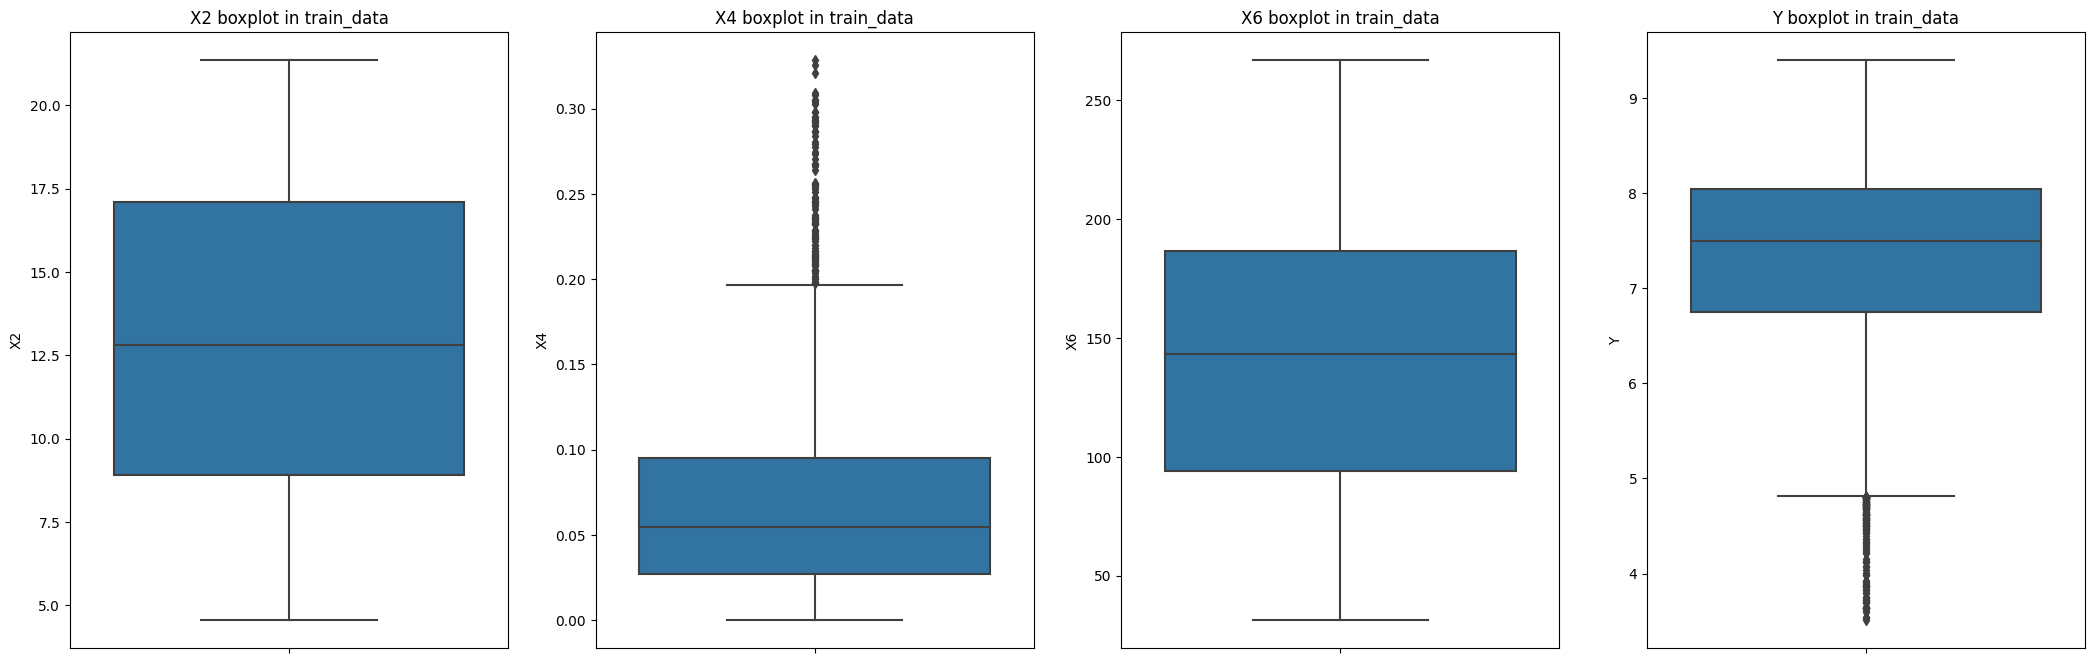

In [26]:
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(26,8))
for index, col in enumerate(numerical_features):
    sns.boxplot(data=train_data, y=col, ax=ax[index])
    ax[index].set_title(f'{col} boxplot in train_data')

# Feature Engineering

In [27]:
# def get_bounds(data, features):
#     outlier_indices = []
    
#     for col in features:
#         Q1 = data[col].quantile(0.25)
#         Q3 = data[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         return lower_bound, upper_bound

# # Replace outliers in X4 with the median value
# lower_bound, upper_bound = get_bounds(train_data, ['X4'])
# train_data['X4'] = np.where(train_data['X4'] > upper_bound, train_data['X4'].median(), train_data['X4'])  
# train_data['X4'] = np.where(train_data['X4'] < lower_bound, train_data['X4'].median(), train_data['X4'])

# # Replace outliers in Y with the median value
# lower_bound, upper_bound = get_bounds(train_data, ['Y'])
# train_data['Y'] = np.where(train_data['Y'] > upper_bound, train_data['Y'].median(), train_data['Y'])
# train_data['Y'] = np.where(train_data['Y'] < lower_bound, train_data['Y'].median(), train_data['Y'])

# # Plotting both 
# _, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 8))

# for i,col in enumerate (['X4', 'Y']):
#   sns.boxplot(data=train_data, y=col, ax=ax[i])
#   ax[i].set_title(f'{col} Boxplot')

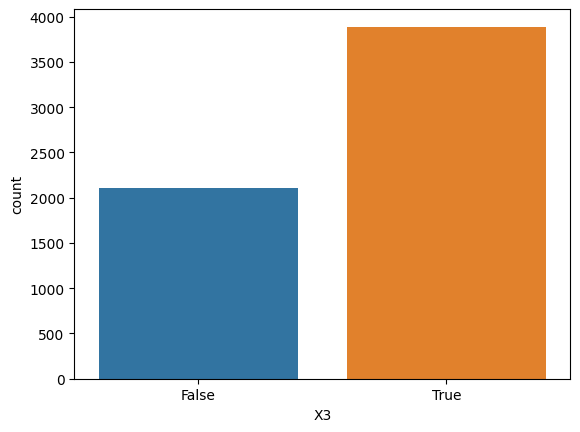

In [28]:
# fix X3 mapping
def fix_X3_mapping(data):
    data['X3'] = data['X3'].map({'Low Fat': 1, 'low fat': 1, 'LF': 1, 'Regular': 0, 'reg': 0}).astype(bool)
    return data 

train_data = fix_X3_mapping(train_data)
test_data = fix_X3_mapping(test_data)

# train_data['X3'] = train_data['X3'].map({'Low Fat': 0,
#                                         'low fat' : 0,
#                                         'LF'      : 0,
#                                         'Regular' : 1,
#                                         'reg'     : 1})


# test_data['X3'] = test_data['X3'].map({'Low Fat' :'Low Fat',
#                                                            'low fat' :"Low Fat",
#                                                            'LF'      :"Low Fat",
#                                                            'Regular' :'Regular',
#                                                            'reg'     :"Regular"
#                                                           })
sns.countplot(x=train_data['X3']);
# they contain {Low Fat, Regular} only 

In [29]:
# Reduce years
# train_data['X8'] = 2024  - train_data['X8']
# test_data['X8'] = 2024  - test_data['X8']
# sns.countplot(x=train_data['X8']);

# Data Preprocessing

## Encoding Categorical Features

In [30]:
# print unique values count 
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    print(f'Number of values in (train, test) {col} column: ({train_data[col].nunique()}, {test_data[col].nunique()})')

categorical_cols

Number of values in (train, test) X1 column: (1553, 1308)
Number of values in (train, test) X5 column: (16, 16)
Number of values in (train, test) X7 column: (10, 10)


['X1', 'X5', 'X7']

**We have 3 categorical features.**
- X1: ID column, maybe we can drop it but later. **TODO:** check if it has any effect on the model
- X5: 16 features
- X7: 10 features 

X5 and X7 need to be encoded. we have several options to encode them:
- One Hot Encoding
- Label Encoding
- Target Encoding
- Frequency Encoding
- Mean Encoding


In [31]:
# Map X9 to numerical values
# train_data['X9'] = train_data['X9'].map({'Small': 1, 'Medium': 2, 'High': 3}).astype(int)
# test_data['X9'] = test_data['X9'].map({'Small': 1, 'Medium': 2, 'High': 3}).astype(int)

# sns.countplot(x=train_data['X9']);

In [32]:
# Map X10 with the tier number
# train_data['X10'] = train_data['X10'].str[-1].astype(int) 
# test_data['X10'] = test_data['X10'].str[-1].astype(int)

# sns.countplot(x=train_data['X10']);

In [33]:
# Column X5 has 16 unique values, column X1 starts with FD, DR, NC, {food, drinks, IDK}, so we can delete X5 and cut X1
# train_data.drop('X5', axis=1, inplace=True)
# test_data.drop('X5', axis=1, inplace=True)

# train_data['X1'] = train_data['X1'].str[:2].map({'FD': 1, 'DR': 2, 'NC': 3}).astype(int)
# test_data['X1'] = test_data['X1'].str[:2].map({'FD': 1, 'DR': 2, 'NC': 3}).astype(int)

# sns.countplot(x=train_data['X1']);

In [34]:
# # Label encoding for X3, X7, X11
# encdr = LabelEncoder()

# # ord_features = ['X3', 'X10', 'X11']
# ord_features = ['X3']

# for feat in ord_features:
#     train_data[feat] = encdr.fit_transform(train_data[feat])
#     test_data[feat] = encdr.transform(test_data[feat])

# train_data.head()

In [35]:
# Encode X7 and X5

# one hot encoding
# train_data = pd.get_dummies(train_data, columns=['X5', 'X7'], drop_first=True)
# test_data = pd.get_dummies(test_data, columns=['X5', 'X7'], drop_first=True)

"""
train_data = pd.get_dummies(train_data, columns=['X5'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['X5'], drop_first=True)
"""

# ordinal encoding
# encdr = OrdinalEncoder()
# train_data['X5'] = encdr.fit_transform(train_data[['X5']])
# test_data['X5'] = encdr.transform(test_data[['X5']])
# train_data['X7'] = encdr.fit_transform(train_data[['X7']])
# test_data['X7'] = encdr.transform(test_data[['X7']])

# frequency encoding
# freq_encoding = train_data.groupby('X5').size() / len(train_data)
# train_data['X5'] = train_data['X5'].map(freq_encoding)
# test_data['X5'] = test_data['X5'].map(freq_encoding)

# freq_encoding = train_data.groupby('X7').size() / len(train_data)
# train_data['X7'] = train_data['X7'].map(freq_encoding)
# test_data['X7'] = test_data['X7'].map(freq_encoding)

# target encoding
# encdr = TargetEncoder()
# train_data['X5'] = encdr.fit_transform(train_data['X5'], train_data['Y'])
# test_data['X5'] = encdr.transform(test_data['X5'])

"""
encdr = TargetEncoder()
train_data['X7'] = encdr.fit_transform(train_data['X7'], train_data['Y'])
test_data['X7'] = encdr.transform(test_data['X7'])
"""

# catboost encoding
for col in ['X1', 'X5', 'X7']:  # Replace with actual column names
    test_data[col] = test_data[col].astype('category')
    train_data[col] = train_data[col].astype('category')


# # X1 label encoding for all ids
# encdr = LabelEncoder()
# train_data['X1'] = encdr.fit_transform(train_data['X1'])
# test_data['X1'] = encdr.fit_transform(test_data['X1'])

# drop X1 TODO we need to decide if we need to drop it or encode it

""" 
train_data.drop('X1', axis=1, inplace=True)
test_data.drop('X1', axis=1, inplace=True)
"""

" \ntrain_data.drop('X1', axis=1, inplace=True)\ntest_data.drop('X1', axis=1, inplace=True)\n"

In [36]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,Y
0,FDA15,9.30,True,0.016047,Dairy,249.8092,OUT049,8.23
1,DRC01,5.92,False,0.019278,Soft Drinks,48.2692,OUT018,6.09
2,FDN15,17.50,True,0.016760,Meat,141.6180,OUT049,7.65
3,FDX07,19.20,False,0.000000,Fruits and Vegetables,182.0950,OUT010,6.60
4,NCD19,8.93,True,0.000000,Household,53.8614,OUT013,6.90


In [37]:
train_data.shape

(6000, 8)

## Scaling Numerical Features

numeric features need to be scaled, we have several options to scale them:
- MinMaxScaler
- StandardScaler
- RobustScaler
- Normalizer
- MaxAbsScaler
- QuantileTransformer
- log transformation

numerical columns: 
- X2
- X4
- X6

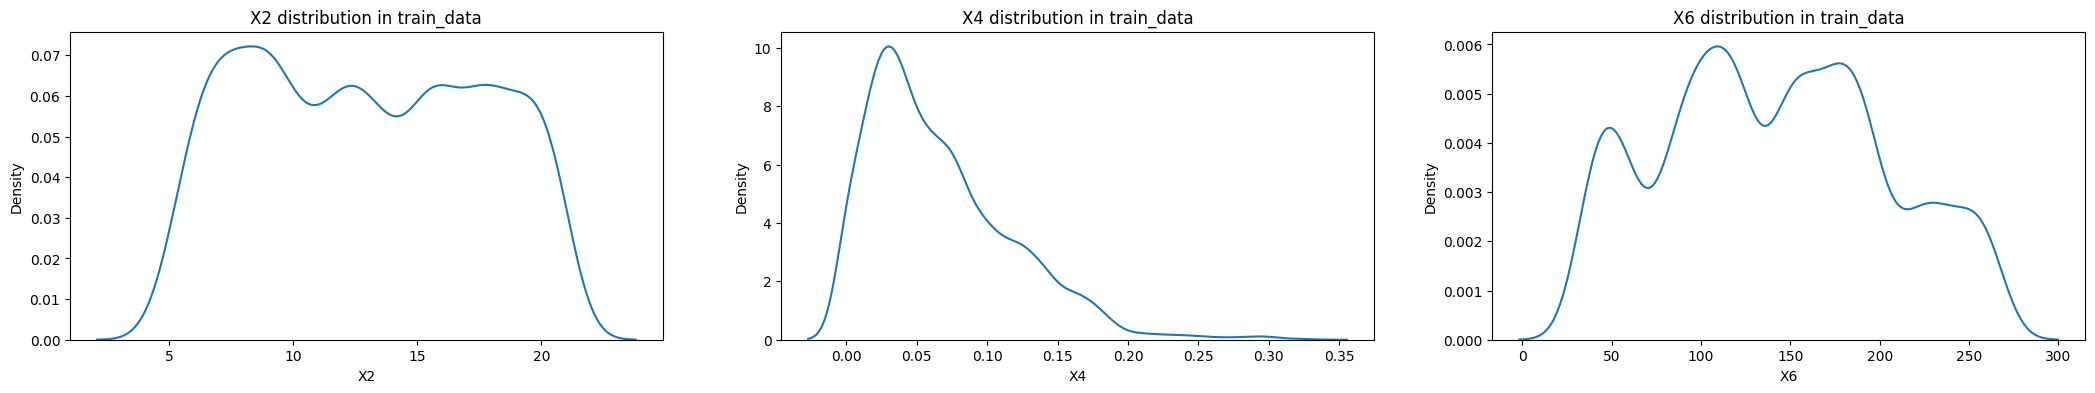

In [38]:
numerical_features = ['X2', 'X4', 'X6']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(numerical_features):
    sns.kdeplot(data=train_data, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in train_data')

In [39]:
# scaling numerical features

# scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = MaxAbsScaler() # best
# scaler = QuantileTransformer()
# scaler = PowerTransformer()

# train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
# test_data[numerical_features] = scaler.transform(test_data[numerical_features])


# we can maxAbs with X2, X6 
max_abs = MaxAbsScaler()
train_data[['X2', 'X6']] = max_abs.fit_transform(train_data[['X2', 'X6']])
test_data[['X2', 'X6']] = max_abs.transform(test_data[['X2', 'X6']])

# log with X4
train_data['X4'] = np.log1p(train_data['X4'])
test_data['X4'] = np.log1p(test_data['X4'])

# log transformation
# train_data[numerical_features] = np.log1p(train_data[numerical_features])
# test_data[numerical_features] = np.log1p(test_data[numerical_features])


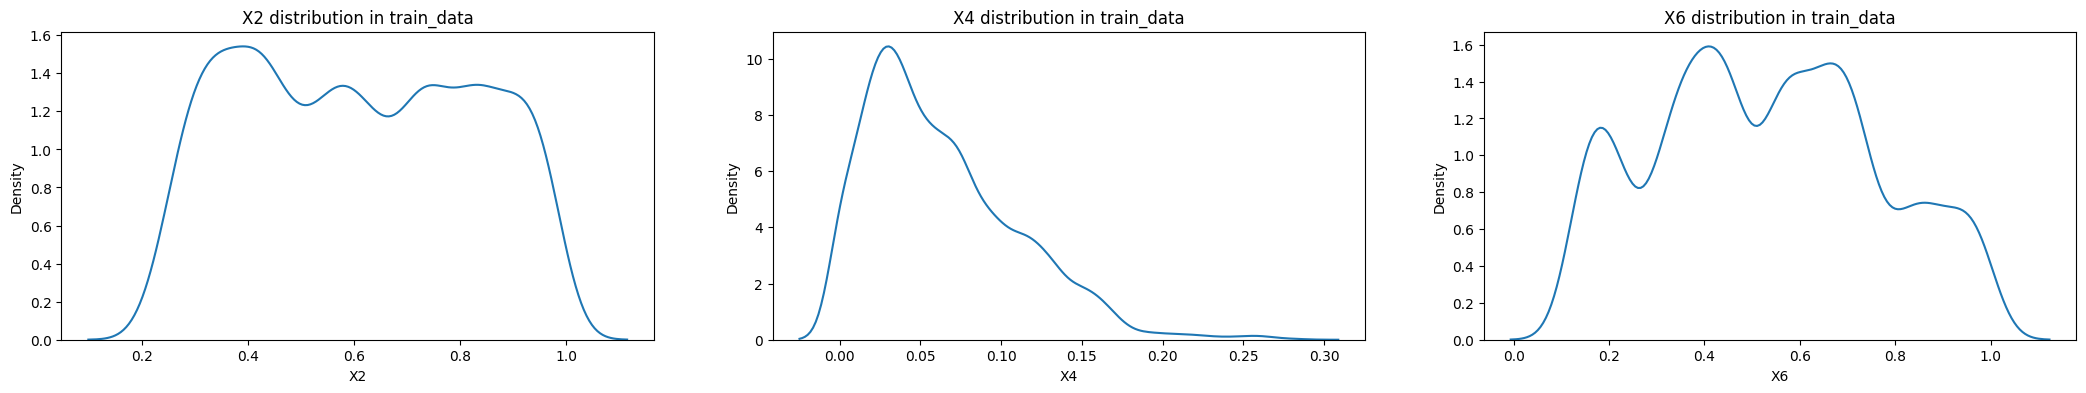

In [40]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(numerical_features):
    sns.kdeplot(data=train_data, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in train_data')

# Model Building

In [41]:
X = train_data.drop('Y', axis=1)
y = train_data['Y']

In [42]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
# # linear regression model
# linear_reg = LinearRegression()
# linear_reg.fit(X_train, y_train)

# # make predictions
# lr_preds = linear_reg.predict(test_data)

# # evaluate the model
# y_pred = linear_reg.predict(X_test)

# train_score = linear_reg.score(X_train, y_train)
# test_score = linear_reg.score(X_test, y_test)
# print(f'Train score: {train_score}')
# print(f'Test score: {test_score}')

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')


In [44]:
# # Ridge regression model
# ridge_pipe = Pipeline([
#             ('poly'  , PolynomialFeatures(degree=2)),
#             ('model' , Ridge(alpha=7, fit_intercept=True))])

# ridge_pipe.fit(X_train, y_train)

# # make predictions
# ridge_preds = ridge_pipe.predict(test_data)

# # evaluate the model
# y_pred = ridge_pipe.predict(X_test)

# train_score = ridge_pipe.score(X_train, y_train)
# test_score = ridge_pipe.score(X_test, y_test)
# print(f'Train score: {train_score}')
# print(f'Test score: {test_score}')

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')

In [45]:
# # Lasso regression model 
# lasso_pipe = Pipeline([
#             ('poly'  , PolynomialFeatures(degree=2)),
#             ('model' , Lasso(alpha=0.001, fit_intercept=True))])

# lasso_pipe.fit(X_train, y_train)

# # make predictions
# lasso_preds = lasso_pipe.predict(test_data)

# # evaluate the model
# y_pred = lasso_pipe.predict(X_test)

# train_score = lasso_pipe.score(X_train, y_train)
# test_score = lasso_pipe.score(X_test, y_test)
# print(f'Train score: {train_score}')
# print(f'Test score: {test_score}')

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')

In [46]:
# # ElasticNet regression model
# elastic_pipe = Pipeline([ ('scaler', StandardScaler()),
#             ('poly'  , PolynomialFeatures(degree=2)),
#             ('model' , ElasticNet(alpha=0.008095665567664173, l1_ratio=0.5375101432152942, fit_intercept=True))])

# elastic_pipe.fit(X, y)

# # make predictions
# elastic_preds = elastic_pipe.predict(test_data)

# # evaluate the model
# y_pred = elastic_pipe.predict(X_test)

# train_score = elastic_pipe.score(X_train, y_train)
# test_score = elastic_pipe.score(X_test, y_test)
# print(f'Train score: {train_score}')
# print(f'Test score: {test_score}')

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')

In [47]:
# # KNeighbors Regressor model
# knn_pipe = Pipeline([('scaler', StandardScaler()),
#             ('model' , KNeighborsRegressor(n_neighbors=17))])

# knn_pipe.fit(X_train, y_train)

# # make predictions
# knn_preds = knn_pipe.predict(test_data)

# # evaluate the model
# y_pred = knn_pipe.predict(X_test)

# train_score = knn_pipe.score(X_train, y_train)
# test_score = knn_pipe.score(X_test, y_test)
# print(f'Train score: {train_score}')
# print(f'Test score: {test_score}')

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')

In [48]:
# # XGBoost Regressor model with tuned hyperparameters
# xgb_pipe = Pipeline([
#     ('model', XGBRegressor(
#         colsample_bylevel=1.0, 
#         colsample_bynode=0.5, 
#         colsample_bytree=1.0, 
#         gamma=1.0, 
#         learning_rate=0.3, 
#         max_depth=5, 
#         n_estimators=50, 
#         reg_alpha=0.5, 
#         reg_lambda=0.5, 
#         subsample=1.0,
#         random_state=42  # Ensure reproducibility
#     ))
# ])

# # Fit the model on training data
# xgb_pipe.fit(X_train, y_train)

# # Make predictions
# xgb_preds_test_data = xgb_pipe.predict(test_data) # For submission
# y_pred = xgb_pipe.predict(X_test)  # For evaluation on validation/test set

# # Evaluate the model
# train_score = xgb_pipe.score(X_train, y_train)
# test_score = xgb_pipe.score(X_test, y_test)

# print(f"Train score (R²): {train_score:.2f}")
# print(f"Test score (R²): {test_score:.2f}")

# # Compute regression metrics
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = mse ** 0.5  # Root Mean Squared Error

# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"Mean Squared Error: {mse:.2f}")
# print(f"Root Mean Squared Error: {rmse:.2f}")

# # Check overfitting
# if abs(train_score - test_score) > 0.1:
#     print("Warning: Model may be overfitting or underfitting.")
# else:
#     print("Model performance is balanced.")

In [49]:
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=21,  
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
)

# Fit the model
lgb_model.fit(X_train, y_train)

# Calculate train and test scores
train_score_lgb = lgb_model.score(X_train, y_train)
test_score_lgb = lgb_model.score(X_test, y_test)

# Make predictions
lgb_preds_test_data = lgb_model.predict(test_data)  # For submission
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model with additional metrics
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

print("LightGBM Results:")
print(f"Train Score (R²): {train_score_lgb:.2f}")
print(f"Test Score (R²): {test_score_lgb:.2f}")
print(f"Mean Absolute Error: {mae_lgb:.2f}")
print(f"Mean Squared Error: {mse_lgb:.2f}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1790
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 7
[LightGBM] [Info] Start training from score 7.314692
LightGBM Results:
Train Score (R²): 0.81
Test Score (R²): 0.72
Mean Absolute Error: 0.42
Mean Squared Error: 0.30


In [50]:
# Define the CatBoost Regressor model
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=3,
    l2_leaf_reg=1e-05,
    bagging_temperature=0.9756667394504983,
    colsample_bylevel=0.5,
    max_bin=100,
    subsample=0.5,
    random_state=42,
    cat_features=['X1', 'X5', 'X7']
)
# Fit the model
catboost_model.fit(X_train, y_train)

# Calculate train and test scores
train_score_cat = catboost_model.score(X_train, y_train)
test_score_cat = catboost_model.score(X_test, y_test)

# Make predictions
catboost_preds_test_data = catboost_model.predict(test_data)  # For submission
y_pred_cat = catboost_model.predict(X_test)

# Evaluate the model with additional metrics
mae_cat = mean_absolute_error(y_test, y_pred_cat)
mse_cat = mean_squared_error(y_test, y_pred_cat)

print("CatBoost Results:")
print(f"Train Score (R²): {train_score_cat:.2f}")
print(f"Test Score (R²): {test_score_cat:.2f}")
print(f"Mean Absolute Error: {mae_cat:.2f}")
print(f"Mean Squared Error: {mse_cat:.2f}")

0:	learn: 1.0028686	total: 56.4ms	remaining: 56.4s
1:	learn: 0.9964071	total: 58.5ms	remaining: 29.2s
2:	learn: 0.9902636	total: 61.7ms	remaining: 20.5s
3:	learn: 0.9840282	total: 64.4ms	remaining: 16s
4:	learn: 0.9784275	total: 65.6ms	remaining: 13.1s
5:	learn: 0.9741206	total: 66.7ms	remaining: 11s
6:	learn: 0.9684674	total: 68ms	remaining: 9.65s
7:	learn: 0.9645996	total: 69.7ms	remaining: 8.64s
8:	learn: 0.9590799	total: 72.1ms	remaining: 7.94s
9:	learn: 0.9533540	total: 73.5ms	remaining: 7.28s
10:	learn: 0.9475538	total: 74.7ms	remaining: 6.71s
11:	learn: 0.9423245	total: 76.1ms	remaining: 6.27s
12:	learn: 0.9370493	total: 77.2ms	remaining: 5.86s
13:	learn: 0.9333953	total: 78.5ms	remaining: 5.53s
14:	learn: 0.9296146	total: 80.4ms	remaining: 5.28s
15:	learn: 0.9263330	total: 82.6ms	remaining: 5.08s
16:	learn: 0.9236765	total: 84.2ms	remaining: 4.87s
17:	learn: 0.9184984	total: 85.7ms	remaining: 4.68s
18:	learn: 0.9132885	total: 87.4ms	remaining: 4.51s
19:	learn: 0.9079520	total: 

In [51]:
# TODO TODO TODO TEST 

# import pandas as pd
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer
# import numpy as np

# catboost_model = CatBoostRegressor(
#     loss_function='MAE',  # Set loss function to Mean Absolute Error
#     cat_features=['X1', 'X5', 'X7'],  # Specify the categorical feature columns
#     random_seed=42,
#     verbose=0  # Disable verbose during optimization
# )

# # Define the parameter search space for Bayesian Optimization
# search_space = {
#     'iterations': Integer(100, 1000),  # Number of boosting iterations
#     'learning_rate': Real(0.01, 0.3),  # Learning rate
#     'depth': Integer(3, 10),  # Depth of the trees
#     'l2_leaf_reg': Real(1e-5, 10.0, prior='log-uniform'),  # L2 regularization
#     'subsample': Real(0.5, 1.0),  # Subsampling
#     'colsample_bylevel': Real(0.5, 1.0),  # Feature sampling per tree
#     'max_bin': Integer(100, 500),  # Max bin size for feature discretization
#     'bagging_temperature': Real(0, 1),  # Bagging temperature for randomness
# }

# # Set up Bayesian Optimization using BayesSearchCV
# opt = BayesSearchCV(
#     catboost_model,
#     search_space,
#     n_iter=20,  # Number of iterations
#     scoring='neg_mean_absolute_error',  # We want to minimize MAE
#     cv=3,  # 3-fold cross-validation
#     n_jobs=1,  # Use all CPU cores
#     verbose=1,
#     random_state=42
# )

# # Fit the model with Bayesian optimization
# opt.fit(X_train, y_train)

# # Get the best parameters found during optimization
# print("Best Parameters: ", opt.best_params_)

# # Best model after optimization
# best_catboost_model = opt.best_estimator_

# # Evaluate the optimized model on the training and test sets
# train_score_cat = best_catboost_model.score(X_train, y_train)
# test_score_cat = best_catboost_model.score(X_test, y_test)

# # Make predictions
# y_pred_cat = best_catboost_model.predict(X_test)

# # Evaluate the model with additional metrics
# mae_cat = mean_absolute_error(y_test, y_pred_cat)
# mse_cat = mean_squared_error(y_test, y_pred_cat)

# # Display the results
# print("CatBoost Optimized Results:")
# print(f"Train Score (R²): {train_score_cat:.2f}")
# print(f"Test Score (R²): {test_score_cat:.2f}")
# print(f"Mean Absolute Error: {mae_cat:.2f}")
# print(f"Mean Squared Error: {mse_cat:.2f}")

After considering the problem, I think the best model for this problem is Random Forest.

In [52]:
# # Random Forest Regressor model
# rf_model = RandomForestRegressor(n_estimators=50, max_depth=5,
#                                   min_samples_leaf=4, min_samples_split=10,
#                                   random_state=42)
# # {'model__bootstrap': True,
# #   'model__max_depth': 5,
# #   'model__max_features': None, 
# #   'model__min_samples_leaf': 4, 
# #   'model__min_samples_split': 10, 
# #  'model__n_estimators': 50}

# rf_pipe = Pipeline([('model', rf_model)]) 

# rf_pipe.fit(X_train, y_train)

# # make predictions
# rf_preds = rf_pipe.predict(test_data)

# # evaluate the model
# y_pred = rf_pipe.predict(X_test)

# train_score = rf_pipe.score(X_train, y_train)
# test_score = rf_pipe.score(X_test, y_test)
# print(f'Train score: {train_score}')
# print(f'Test score: {test_score}')

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')

In [53]:
# # Define hyperparameter grid

# ? find best parameters for Random Forest Regressor
# param_grid = {
#     'model__n_estimators': [50, 100, 200, 500],
#     'model__max_depth': [5, 10, 20, None],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
#     'model__max_features': ['sqrt', 'log2', None],
#     'model__bootstrap': [True, False]
# }

# # Grid search
# grid_search = GridSearchCV(
#     estimator=rf_pipe,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # make predictions
# rf_y_pred = grid_search.predict(X_test)

# # Best parameters and MAE
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best MAE: {grid_search.best_score_}")

# # evaluate the model
# print(f'train score: {grid_search.score(X_train, y_train)}')
# print(f'test score: {grid_search.score(X_test, y_test)}')
# rf_mae = mean_absolute_error(y_test, rf_y_pred)
# rf_mse = mean_squared_error(y_test, rf_y_pred)

# print(f'Mean Absolute Error: {rf_mae}')
# print(f'Mean Squared Error: {rf_mse}')

# ? find best parameters for XGBoost Regressor
# param_grid = {
#     'model__n_estimators': [50, 100, 200],
#     'model__max_depth': [5, 7],
#     'model__learning_rate': [0.01, 0.1, 0.3],
#     'model__subsample': [0.5, 0.7, 1.0],
#     'model__colsample_bytree': [0.5, 0.7, 1.0],
#     'model__colsample_bylevel': [0.5, 0.7, 1.0],
#     'model__colsample_bynode': [0.5, 0.7, 1.0],
#     'model__gamma': [0, 0.25, 0.5, 1.0],
#     'model__reg_alpha': [0, 0.5, 1.0],
#     'model__reg_lambda': [0.5, 1.0, 2.0]
# }

# # Grid search
# grid_search = GridSearchCV(
#     estimator=xgb_pipe,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # make predictions
# xgb_y_pred = grid_search.predict(X_test)

# # Best parameters and MAE
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best MAE: {grid_search.best_score_}")

# # evaluate the model
# print(f'train score: {grid_search.score(X_train, y_train)}')
# print(f'test score: {grid_search.score(X_test, y_test)}')
# xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
# xgb_mse = mean_squared_error(y_test, xgb_y_pred)

# print(f'Mean Absolute Error: {xgb_mae}')
# print(f'Mean Squared Error: {xgb_mse}')

In [54]:
# Save results
print(f'file len={len(catboost_preds_test_data)}') # Should be 2523

# Create the submission file
submission = pd.DataFrame({
    'row_id': range(len(catboost_preds_test_data)),
    'Y': catboost_preds_test_data
})

submission.to_csv('RESULTS.csv', index=False)
print("Predictions saved to 'RESULTS.csv'!!!")

file len=2523
Predictions saved to 'RESULTS.csv'!!!
